In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:01<00:00, 122.05it/s]


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


__________________________________________________________________________________________________


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseV16(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8604

60/60 [==============================] - 165s 2s/step - loss: 0.3215 - accuracy: 0.8604 - val_loss: 0.0721 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9521

60/60 [==============================] - 82s 1s/step - loss: 0.1312 - accuracy: 0.9521 - val_loss: 0.0207 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9604

60/60 [==============================] - 81s 1s/step - loss: 0.1077 - accuracy: 0.9604 - val_loss: 0.0129 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9656

60/60 [==============================] - 82s 1s/step - loss: 0.0892 - accuracy: 0.9656 - val_loss: 0.0124 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/50
60/60 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9708

60/60 [==============================] - 81s 1s/step - loss: 0.0722 - accuracy: 0.9708 - val_loss: 0.0121 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/50
60/60 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9724

60/60 [==============================] - 81s 1s/step - loss: 0.0684 - accuracy: 0.9724 - val_loss: 0.0098 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/50
60/60 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9703

60/60 [==============================] - 81s 1s/step - loss: 0.0757 - accuracy: 0.9703 - val_loss: 0.0257 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 8/50
60/60 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9714

60/60 [==============================] - 82s 1s/step - loss: 0.0683 - accuracy: 0.9714 - val_loss: 0.0132 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 9/50
60/60 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9724

60/60 [==============================] - 82s 1s/step - loss: 0.0610 - accuracy: 0.9724 - val_loss: 0.0193 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 10/50
60/60 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9745

60/60 [==============================] - 81s 1s/step - loss: 0.0617 - accuracy: 0.9745 - val_loss: 0.0291 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 11/50
60/60 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9698

60/60 [==============================] - 81s 1s/step - loss: 0.0671 - accuracy: 0.9698 - val_loss: 0.0036 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/50
60/60 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9818

60/60 [==============================] - 81s 1s/step - loss: 0.0510 - accuracy: 0.9818 - val_loss: 0.0070 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 13/50
60/60 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9776

60/60 [==============================] - 82s 1s/step - loss: 0.0513 - accuracy: 0.9776 - val_loss: 0.0103 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/50
60/60 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9781

60/60 [==============================] - 81s 1s/step - loss: 0.0576 - accuracy: 0.9781 - val_loss: 0.0054 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15/50
60/60 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9708

60/60 [==============================] - 81s 1s/step - loss: 0.0576 - accuracy: 0.9708 - val_loss: 0.0058 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/50
60/60 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9745

60/60 [==============================] - 81s 1s/step - loss: 0.0581 - accuracy: 0.9745 - val_loss: 0.0046 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/50
60/60 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9792

60/60 [==============================] - 82s 1s/step - loss: 0.0474 - accuracy: 0.9792 - val_loss: 0.0059 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/50
60/60 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9719

60/60 [==============================] - 82s 1s/step - loss: 0.0603 - accuracy: 0.9719 - val_loss: 0.0060 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/50
60/60 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9823

60/60 [==============================] - 81s 1s/step - loss: 0.0425 - accuracy: 0.9823 - val_loss: 0.0039 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/50
60/60 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9755

60/60 [==============================] - 81s 1s/step - loss: 0.0505 - accuracy: 0.9755 - val_loss: 0.0042 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/50
60/60 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9823

60/60 [==============================] - 81s 1s/step - loss: 0.0381 - accuracy: 0.9823 - val_loss: 0.0034 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 22/50
60/60 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9828

60/60 [==============================] - 82s 1s/step - loss: 0.0367 - accuracy: 0.9828 - val_loss: 0.0032 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/50
60/60 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9807

60/60 [==============================] - 81s 1s/step - loss: 0.0520 - accuracy: 0.9807 - val_loss: 0.0025 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/50
60/60 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9792

60/60 [==============================] - 82s 1s/step - loss: 0.0459 - accuracy: 0.9792 - val_loss: 0.0031 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/50
60/60 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9760

60/60 [==============================] - 81s 1s/step - loss: 0.0530 - accuracy: 0.9760 - val_loss: 0.0016 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 26/50
60/60 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9792

60/60 [==============================] - 81s 1s/step - loss: 0.0450 - accuracy: 0.9792 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/50
60/60 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9849

60/60 [==============================] - 82s 1s/step - loss: 0.0365 - accuracy: 0.9849 - val_loss: 0.0073 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 28/50
60/60 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9786

60/60 [==============================] - 81s 1s/step - loss: 0.0431 - accuracy: 0.9786 - val_loss: 0.0020 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/50
60/60 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9833

60/60 [==============================] - 82s 1s/step - loss: 0.0353 - accuracy: 0.9833 - val_loss: 0.0075 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 30/50
60/60 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9818

60/60 [==============================] - 81s 1s/step - loss: 0.0414 - accuracy: 0.9818 - val_loss: 0.0031 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 31/50
60/60 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9833

60/60 [==============================] - 81s 1s/step - loss: 0.0373 - accuracy: 0.9833 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 32/50
60/60 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9797

60/60 [==============================] - 82s 1s/step - loss: 0.0422 - accuracy: 0.9797 - val_loss: 0.0040 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 33/50
60/60 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9870

60/60 [==============================] - 81s 1s/step - loss: 0.0324 - accuracy: 0.9870 - val_loss: 0.0051 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 34/50
60/60 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9797

60/60 [==============================] - 81s 1s/step - loss: 0.0428 - accuracy: 0.9797 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 35/50
60/60 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9802

60/60 [==============================] - 82s 1s/step - loss: 0.0429 - accuracy: 0.9802 - val_loss: 0.0100 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 36/50
60/60 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9797

60/60 [==============================] - 81s 1s/step - loss: 0.0369 - accuracy: 0.9797 - val_loss: 0.0030 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 37/50
60/60 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9833

60/60 [==============================] - 81s 1s/step - loss: 0.0420 - accuracy: 0.9833 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 38/50
60/60 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9818

60/60 [==============================] - 81s 1s/step - loss: 0.0363 - accuracy: 0.9818 - val_loss: 0.0019 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 39/50
60/60 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9891

60/60 [==============================] - 81s 1s/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.0026 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 40/50
60/60 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9844

60/60 [==============================] - 82s 1s/step - loss: 0.0371 - accuracy: 0.9844 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 41/50
60/60 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9865

60/60 [==============================] - 82s 1s/step - loss: 0.0252 - accuracy: 0.9865 - val_loss: 0.0035 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 42/50
60/60 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9812

60/60 [==============================] - 81s 1s/step - loss: 0.0386 - accuracy: 0.9812 - val_loss: 0.0016 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 43/50
60/60 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9828

60/60 [==============================] - 81s 1s/step - loss: 0.0329 - accuracy: 0.9828 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 44/50
60/60 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9854

60/60 [==============================] - 81s 1s/step - loss: 0.0342 - accuracy: 0.9854 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 45/50
60/60 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9786

60/60 [==============================] - 81s 1s/step - loss: 0.0412 - accuracy: 0.9786 - val_loss: 0.0035 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 46/50
60/60 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9828

60/60 [==============================] - 82s 1s/step - loss: 0.0331 - accuracy: 0.9828 - val_loss: 0.0019 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 47/50
60/60 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9865

60/60 [==============================] - 81s 1s/step - loss: 0.0288 - accuracy: 0.9865 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 48/50
60/60 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9849

60/60 [==============================] - 81s 1s/step - loss: 0.0318 - accuracy: 0.9849 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 49/50
60/60 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9849

60/60 [==============================] - 82s 1s/step - loss: 0.0354 - accuracy: 0.9849 - val_loss: 0.0010 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 50/50
60/60 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9854

60/60 [==============================] - 81s 1s/step - loss: 0.0333 - accuracy: 0.9854 - val_loss: 0.0025 - val_accuracy: 1.0000 - lr: 1.0000e-04


20/20 [==============================] - 16s 595ms/step
Confusion matrix, without normalization
[[204   0   2]
 [  0 200   0]
 [  0   0 205]]


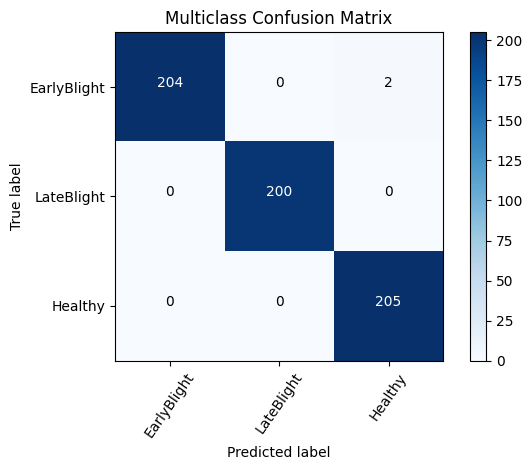

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 6s 320ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       1.00      0.99      1.00       206
  LateBlight       1.00      1.00      1.00       200
     Healthy       0.99      1.00      1.00       205

    accuracy                           1.00       611
   macro avg       1.00      1.00      1.00       611
weighted avg       1.00      1.00      1.00       611



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 6s 325ms/step
MultiNet(ResNet50,DenseNet201,VGG16)
Accuracy: 0.9967266775777414
F1 Score: 0.9967267163336309
precision: 0.9967584574070837
recall: 0.9967266775777414
MSE: 0.01309328968903437
MAE: 0.006546644844517185


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

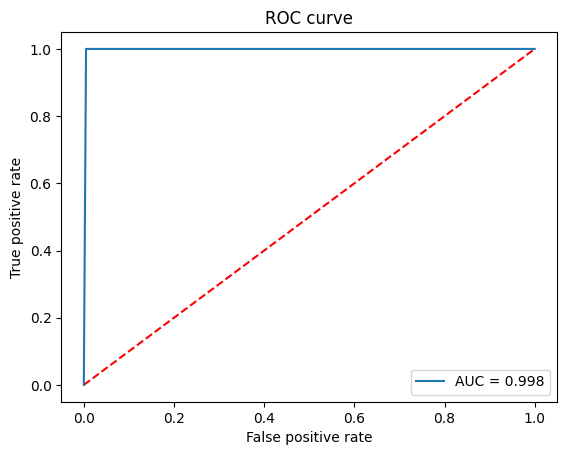

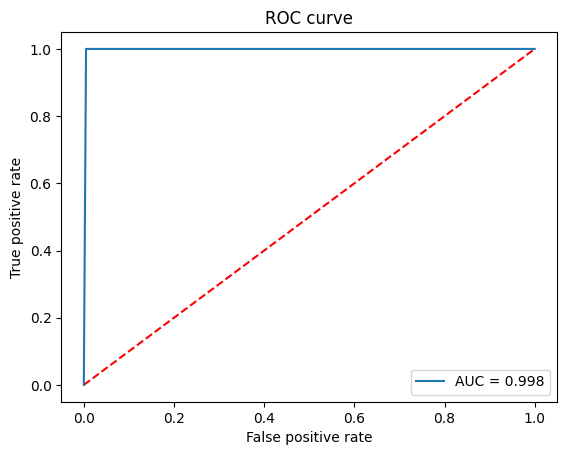

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
